In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBRegressor
import warnings
%matplotlib inline

# Turn off the nagging warnings from sklearn and seaborn
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [203]:
# Read core training and test data
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [204]:
train_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [205]:
# see https://www.datacamp.com/community/tutorials/categorical-data

In [206]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


In [207]:
train_data['OutcomeType'].value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

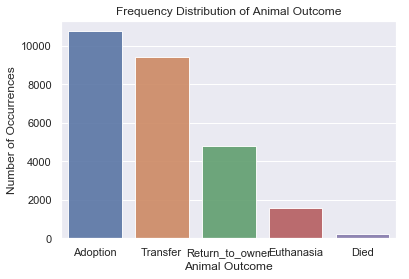

In [208]:
outcome_count = train_data['OutcomeType'].value_counts()
sns.set(style="darkgrid")
sns.barplot(outcome_count.index, outcome_count.values, alpha=0.9)
plt.title('Frequency Distribution of Animal Outcome')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Animal Outcome', fontsize=12)
plt.show()

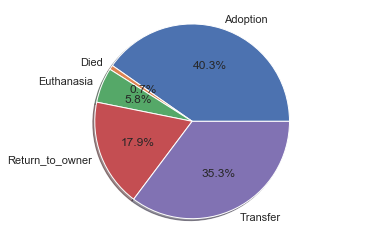

In [209]:
labels = train_data['OutcomeType'].astype('category').cat.categories.tolist()
counts = train_data['OutcomeType'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

In [210]:
replace_map = {'OutcomeType': {'Adoption': 1, 'Transfer': 2, 'Return_to_owner': 3, 'Euthanasia': 4,
                                  'Died': 5}}

In [211]:
# copied so we can practice each encoding technique
train_data_replace = train_data.copy()

In [212]:
train_data_replace.replace(replace_map, inplace=True)

In [213]:
print(train_data_replace.head())

  AnimalID     Name             DateTime  OutcomeType OutcomeSubtype  \
0  A671945  Hambone  2014-02-12 18:22:00            3            NaN   
1  A656520    Emily  2013-10-13 12:44:00            4      Suffering   
2  A686464   Pearce  2015-01-31 12:28:00            1         Foster   
3  A683430      NaN  2014-07-11 19:09:00            2        Partner   
4  A667013      NaN  2013-11-15 12:52:00            2        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color  
0  Brown/White  
1  Cream Tabby  
2   Blue/White  
3   Blue Cream  
4          Tan  


In [214]:
train_data_replace.drop(['AnimalID'], inplace=True, axis=1)

In [215]:
train_data_replace['OutcomeSubtype'].isna().sum()

13612

In [216]:
train_data_replace['OutcomeSubtype'].replace(np.nan, 'Unknown', regex=True, inplace=True)

In [217]:
train_data_replace.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,Hambone,2014-02-12 18:22:00,3,Unknown,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,Emily,2013-10-13 12:44:00,4,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,Pearce,2015-01-31 12:28:00,1,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,NaN,2014-07-11 19:09:00,2,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,NaN,2013-11-15 12:52:00,2,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [218]:
import re
import math

In [219]:
def to_years(row):
    row = str(row)
    if "nan" in row.lower():
        return row
    
    digit = int(re.findall('\d+', row )[0]) * 1.0

    if('year' in row):
        return digit
    elif('month' in row):
        return digit / 12.0
    elif('week' in row):
        return digit / 52.0
    elif('day' in row):
        return digit / 365.0
    else:
        return digit
    

In [220]:
train_data_replace['AgeuponOutcome'] = train_data_replace['AgeuponOutcome'].apply(to_years) 

In [221]:
train_data_replace['AgeuponOutcome'].head()

0            1
1            1
2            2
3    0.0576923
4            2
Name: AgeuponOutcome, dtype: object

In [222]:
train_data_replace.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,Hambone,2014-02-12 18:22:00,3,Unknown,Dog,Neutered Male,1,Shetland Sheepdog Mix,Brown/White
1,Emily,2013-10-13 12:44:00,4,Suffering,Cat,Spayed Female,1,Domestic Shorthair Mix,Cream Tabby
2,Pearce,2015-01-31 12:28:00,1,Foster,Dog,Neutered Male,2,Pit Bull Mix,Blue/White
3,NaN,2014-07-11 19:09:00,2,Partner,Cat,Intact Male,0.0576923,Domestic Shorthair Mix,Blue Cream
4,NaN,2013-11-15 12:52:00,2,Partner,Dog,Neutered Male,2,Lhasa Apso/Miniature Poodle,Tan


In [223]:
train_data_replace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 9 columns):
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null int64
OutcomeSubtype    26729 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26729 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: int64(1), object(8)
memory usage: 1.8+ MB


### Sometimes, you might just want to encode a bunch of categories within a feature to some numeric value and encode all the other categories to some other numeric value. You could do this by using numpy's where() function 

In [238]:
#train_data_replace['Deceased'] = np.where(train_data_replace['OutcomeType'] == 5, 1, 0)

In [251]:
train_data_replace['Deceased'] = (train_data_replace['OutcomeType'] == 5) | (train_data_replace['OutcomeType'] == 4)
train_data_replace['Deceased'] = train_data_replace['Deceased'].astype('category')


In [252]:
train_data_replace['Deceased'] = train_data_replace['Deceased'].cat.codes

In [254]:
train_data_replace['Deceased']

0        0
1        1
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
26699    1
26700    0
26701    0
26702    1
26703    0
26704    0
26705    0
26706    0
26707    1
26708    0
26709    0
26710    0
26711    0
26712    0
26713    1
26714    0
26715    0
26716    0
26717    0
26718    0
26719    0
26720    0
26721    0
26722    0
26723    0
26724    0
26725    0
26726    0
26727    0
26728    0
Name: Deceased, Length: 26729, dtype: int8

###  in Python, it's a good practice to typecast categorical features to a category dtype because they make the operations on such columns much faster than the object dtype. You can do the typecasting by using .astype() method 

In [255]:
train_data_replace['OutcomeType'] = train_data_replace['OutcomeType'].astype('category')
train_data_replace['OutcomeSubtype'] = train_data_replace['OutcomeSubtype'].astype('category')
train_data_replace['AnimalType'] = train_data_replace['AnimalType'].astype('category')
train_data_replace['SexuponOutcome'] = train_data_replace['SexuponOutcome'].astype('category')
train_data_replace['Breed'] = train_data_replace['Breed'].astype('category')


In [256]:
train_data_replace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null category
OutcomeSubtype    26729 non-null category
AnimalType        26729 non-null category
SexuponOutcome    26729 non-null category
AgeuponOutcome    26729 non-null object
Breed             26729 non-null category
Color             26729 non-null object
Deceased          26729 non-null int8
dtypes: category(5), int8(1), object(4)
memory usage: 1.0+ MB


In [257]:
train_data_replace['Deceased'] = np.where(train_data_replace['OutcomeType'].str.contains('Died'), 1, 0)
train_data_replace['Deceased'] = np.where(train_data_replace['OutcomeType'].str.contains('Euthanasia'), 1, 0)

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

### Another approach is to encode categorical values with a technique called "label encoding", which allows you to convert each value in a column to a number

In [258]:
train_data_replace['OutcomeSubtype'] = train_data_replace['OutcomeSubtype'].cat.codes
train_data_replace['AnimalType'] = train_data_replace['AnimalType'].cat.codes
train_data_replace['SexuponOutcome'] = train_data_replace['SexuponOutcome'].cat.codes
train_data_replace['Breed'] = train_data_replace['Breed'].cat.codes


In [259]:
train_data_replace.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Deceased
0,Hambone,2014-02-12 18:22:00,3,16,1,3,1,1221,Brown/White,0
1,Emily,2013-10-13 12:44:00,4,15,0,4,1,640,Cream Tabby,1
2,Pearce,2015-01-31 12:28:00,1,6,1,3,2,1066,Blue/White,0
3,NaN,2014-07-11 19:09:00,2,12,0,2,0.0576923,640,Blue Cream,0
4,NaN,2013-11-15 12:52:00,2,12,1,3,2,914,Tan,0


In [260]:
train_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan
